# Particle Filter with JAX

**Martin Lysy, University of Waterloo**

**November 11, 2021**

## Summary

The goal is to provide a fast implementation of a particle filter to estimate the marginal likelihood of a state-space model,
$$
\begin{aligned}
\mathcal{L}(\theta) & = p(y_{0:T} \mid \theta) \\
& = \int \prod_{t=0}^T p(y_t \mid x_t, \theta) \times \prod_{t=1}^T p(x_t \mid x_{t-1}, \theta) \times p(x_0 \mid \theta)\, d x_{0:T},   
\end{aligned}
$$
along with its gradient, $\nabla \mathcal{L}(\theta) = \frac{\partial}{\partial \theta} \mathcal{L}(\theta)$.  The [**JAX**](https://github.com/google/jax) library is used to efficiently compose jit and autodiff operations  in order to achieve this.

## Notation

### Functions

- `state_lpdf(x_curr, x_last, theta)`: Log-density of $p(x_t | x_{t-1}, \theta)$.
- `state_sample(x_last, theta)`: Sample from $p(x_t | x_{t-1}, \theta)$.
- `meas_lpdf(y_curr, x_curr, theta)`: Log-density of $p(y_t | x_t, \theta)$.
- `meas_sample(x_curr, theta)`: Sample from $p(y_t | x_t, \theta)$.

### Dimensions

- `n_obs`: Number of time points.
- `n_particle`: Number of particles.
- `n_state`: Tuple of state dimensions.
- `n_meas`: Tuple of measured dimensions.

## TODO

- [ ] Test against true BM likelihood.

- [x] Data should be $y_{0:T}$ instead of $y_{1:T}$.  This has been changed in some of the documentation but not all of it...

- [x] Add arbitrary prior specification $p(x_0 \mid \theta)$.  Should also be able to specify $x_0$ directly to calculate the marginal likelihood $\mathcal{L}(x_0, \theta) = p(y_{0:T} \mid x_0, \theta)$.

- [ ] Example where `n_state` and `n_meas` are not scalar.  This can be SDE with `n_res > 1`.

- [ ] Interface for supplying new models to generic PF code.  Specifically, if we have `import pfjax as pfj` then we may need to JIT something like 

    ```python
    def my_pf(theta):
        out = pfj.particle_filter(y_meas, theta, n_particles,
                                  my_state_sample, my_meas_lpdf,
                                  *args, **kwargs)
        return pfj.particle_loglik(out)
    ```
    
    Or, perhaps instead we can create a `my_pf` object and then `jax.jit(my_pf.loglik)(theta)`?
    
- [ ] Add arbitrary proposal distribution $q(x_t \mid x_{t-1}, \theta)$.  This should perhaps be done using:

    ```python
    step_sample(x_prev, t, theta)
    step_logw(x_curr, x_prev, t, theta)
    ```
    
    instead of e.g., `state_prop_lpdf()`, `state_targ_lpdf()` and `meas_lpdf()` which gets assembled internally for the user.  This is what was done in [**SMCTC**](https://warwick.ac.uk/fac/sci/statistics/staff/academic-research/johansen/smctc/).  But what are the right args to these functions?  Sort of depends if they know about the "global" `y_meas`...

## Example: Brownian motion with drift

The model is
$$
\newcommand{\N}{\mathcal{N}}
\newcommand{\dt}{\Delta t}
\begin{aligned}
x_0 & \sim \pi(x_0) \\
x_t & \sim \N(x_{t-1} + \mu \dt, \sigma^2 \dt) \\
y_t & \sim \N(x_t, \tau^2).
\end{aligned}
$$

Therefore, `n_state` = `n_meas` = 1, and we have a "global" constant $\dt$ through which we never need to take derivatives.  

Note that with $\pi(x_0) \propto 1$, we may condition on $y_0$ and obtain $x_0 \mid y_0 \sim \N(y_0, \tau^2)$.

### Using JAX

In [1]:
# %load bm_model_jax.py
"""
Brownian motion state space model in JAX.
"""

import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import random


# state-space dimensions
n_meas = 1
n_state = 1


def state_lpdf(x_curr, x_prev, theta):
    """
    Calculates the log-density of `p(x_curr | x_prev, theta)`.

    Args:
        x_curr: State variable at current time `t`.
        x_prev: State variable at previous time `t-1`.
        theta: Parameter value.

    Returns:
        The log-density of `p(x_curr | x_prev, theta)`.
    """
    mu = theta[0]
    sigma = theta[1]
    return jnp.squeeze(
        jsp.stats.norm.logpdf(x_curr, loc=x_prev + mu * dt,
                              scale=sigma * jnp.sqrt(dt))
    )


def state_sample(x_prev, theta, key):
    """
    Samples from `x_curr ~ p(x_curr | x_prev, theta)`.

    Args:
        x_prev: State variable at previous time `t-1`.
        theta: Parameter value.
        key: PRNG key.

    Returns:
        Sample of the state variable at current time `t`: `x_curr ~ p(x_curr | x_prev, theta)`.
    """
    mu = theta[0]
    sigma = theta[1]
    x_mean = x_prev + mu * dt
    x_sd = sigma * jnp.sqrt(dt)
    return x_mean + x_sd * random.normal(key=key)


def meas_lpdf(y_curr, x_curr, theta):
    """
    Log-density of `p(y_curr | x_curr, theta)`.

    Args:
        y_curr: Measurement variable at current time `t`.
        x_curr: State variable at current time `t`.
        theta: Parameter value.

    Returns
        The log-density of `p(x_curr | x_prev, theta)`.
    """
    tau = theta[2]
    return jnp.squeeze(
        jsp.stats.norm.logpdf(y_curr, loc=x_curr, scale=tau)
    )


def meas_sample(x_curr, theta, key):
    """
    Sample from `p(y_curr | x_curr, theta)`.

    Args:
        x_curr: State variable at current time `t`.
        theta: Parameter value.
        key: PRNG key.

    Returns:
        Sample of the measurement variable at current time `t`: `y_curr ~ p(y_curr | x_curr, theta)`.
    """
    tau = theta[2]
    return x_curr + tau * random.normal(key=key)


def init_logw(x_init, y_init, theta):
    """
    Log-weight of the importance sampler for initial state variable `x_init`.

    Suppose that 
    ```
    x_init ~ q(x_init) = q(x_init | y_init, theta)
    ```
    Then function returns
    ```
    logw = log p(x_init | theta) - log q(x_init)
    ```

    Args:
        x_init: State variable at initial time `t = 0`.
        y_init: Measurement variable at initial time `t = 0`.
        theta: Parameter value.

    Returns:
        The log-weight of the importance sampler for `x_init`.
    """
    return -meas_lpdf(x_init, y_init, theta)


def init_sample(y_init, theta, key):
    """
    Sampling distribution for initial state variable `x_init`. 

    Samples from an importance sampling proposal distribution
    ```
    x_init ~ q(x_init) = q(x_init | y_init, theta)
    ```
    See `init_logw()` for details.

    Args:
        y_init: Measurement variable at initial time `t = 0`.
        theta: Parameter value.
        key: PRNG key.

    Returns:
        Sample from the proposal distribution for `x_init`.
    """
    return meas_sample(y_init, theta, key)


In [2]:
# %load particle_filter_jax.py
"""
Particle filter in JAX.

Uses the same API as NumPy/SciPy version.
"""

import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import random


def meas_sim(n_obs, x_init, theta, key):
    """
    Simulate data from the state-space model.

    Args:
        n_obs: Number of observations to generate.
        x_init: Initial state value at time `t = 0`.
        theta: Parameter value.
        key: PRNG key.

    Returns:
        y_meas: The sequence of measurement variables `y_meas = (y_0, ..., y_T)`, where `T = n_obs-1`.
        x_state: The sequence of state variables `x_state = (x_0, ..., x_T)`, where `T = n_obs-1`.
    """
    y_meas = jnp.zeros((n_obs, n_meas))
    x_state = jnp.zeros((n_obs, n_state))
    x_state = x_state.at[0].set(x_init)
    for t in range(1, n_obs):
        key, *subkeys = random.split(key, num=3)
        x_state = x_state.at[t].set(
            state_sample(x_state[t-1], theta, subkeys[0])
        )
        y_meas = y_meas.at[t].set(meas_sample(x_state[t], theta, subkeys[1]))
    return y_meas, x_state


def particle_resample(logw, key):
    """
    Particle resampler.

    This basic one just does a multinomial sampler, i.e., sample with replacement proportional to weights.

    Args:
        logw: Vector of `n_particles` unnormalized log-weights.
        key: PRNG key.

    Returns:
        Vector of `n_particles` integers between 0 and `n_particles-1`, sampled with replacement with probability vector `exp(logw) / sum(exp(logw))`.
    """
    wgt = jnp.exp(logw - jnp.max(logw))
    prob = wgt / jnp.sum(wgt)
    n_particles = logw.size
    return random.choice(key,
                         a=jnp.arange(n_particles), shape=(n_particles,), p=prob)


def particle_filter(y_meas, theta, n_particles, key):
    """
    Apply particle filter for given value of `theta`.

    Closely follows Algorithm 2 of https://arxiv.org/pdf/1306.3277.pdf.

    Args:
        y_meas: The sequence of `n_obs` measurement variables `y_meas = (y_0, ..., y_T)`, where `T = n_obs-1`.
        theta: Parameter value.
        n_particles: Number of particles.
        key: PRNG key.

    Returns:
        A dictionary with elements:
            - `X_particles`: An `ndarray` with leading dimensions `(n_obs, n_particles)` containing the state variable particles.
            - `logw_particles`: An `ndarray` of shape `(n_obs, n_particles)` giving the unnormalized log-weights of each particle at each time point.
            - `ancestor_particles`: An integer `ndarray` of shape `(n_obs, n_particles)` where each element gives the index of the particle's ancestor at the previous time point.  Since the first time point does not have ancestors, the first row of `ancestor_particles` contains all `-1`.
    """
    # memory allocation
    n_obs = y_meas.shape[0]
    X_particles = jnp.zeros((n_obs, n_particles, n_state))
    logw_particles = jnp.zeros((n_obs, n_particles))
    ancestor_particles = jnp.zeros((n_obs, n_particles), dtype=int)
    # initial particles have no ancestors
    ancestor_particles = ancestor_particles.at[0].set(-1)
    # initial time point
    key, *subkeys = random.split(key, num=n_particles+1)
    X_particles = X_particles.at[0].set(
        jax.vmap(lambda k: init_sample(y_meas[0], theta, k))(
            jnp.array(subkeys)
        )
    )
    logw_particles = logw_particles.at[0].set(
        jax.vmap(lambda xs: init_logw(xs, y_meas[0], theta) +
                 meas_lpdf(y_meas[0], xs, theta))(X_particles[0])
    )
    # subsequent time points
    for t in range(1, n_obs):
        # resampling step
        key, subkey = random.split(key)
        ancestor_particles = ancestor_particles.at[t].set(
            particle_resample(logw_particles[t-1], subkey)
        )
        # update
        key, *subkeys = random.split(key, num=n_particles+1)
        X_particles = X_particles.at[t].set(
            jax.vmap(lambda xs, k: state_sample(xs, theta, k))(
                X_particles[t-1, ancestor_particles[t]], jnp.array(subkeys)
            )
        )
        logw_particles = logw_particles.at[t].set(
            jax.vmap(lambda xs: meas_lpdf(y_meas[t], xs, theta))(
                X_particles[t]
            )
        )
    return {
        "X_particles": X_particles,
        "logw_particles": logw_particles,
        "ancestor_particles": ancestor_particles
    }


In [3]:
# %load test_particle_filter_jax.py
key = random.PRNGKey(0)

# parameter values
mu = 5
sigma = 1
tau = .1
theta = jnp.array([mu, sigma, tau])

print(theta)

# data specification
dt = .1
n_obs = 5
x_init = jnp.array([0.])

# simulate data
key, subkey = random.split(key)
y_meas, x_state = meas_sim(n_obs, x_init, theta, subkey)

print("y_meas = \n", y_meas)
print("x_init = \n", x_init)
print("x_state = \n", x_state)

# run particle filter
n_particles = 7
key, subkey = random.split(key)
particle_filter_jitted = jax.jit(particle_filter, static_argnums=(2,))
pf_out = particle_filter_jitted(y_meas, theta, n_particles, subkey)

print("pf_out = \n", pf_out)


[5.  1.  0.1]
y_meas = 
 [[0.        ]
 [0.44947725]
 [0.68188113]
 [0.91331539]
 [1.05404084]]
x_init = 
 [0.]
x_state = 
 [[0.        ]
 [0.4394778 ]
 [0.60337457]
 [0.88978651]
 [1.07383932]]
pf_out = 
 {'X_particles': DeviceArray([[[-6.21298687e-02],
              [-2.09634208e-02],
              [-1.16327993e-03],
              [ 3.70711288e-02],
              [ 2.35676415e-01],
              [-1.67398051e-02],
              [ 1.25699265e-01]],

             [[ 8.37142026e-01],
              [ 9.73443256e-01],
              [ 8.91045447e-01],
              [ 5.95458532e-01],
              [ 3.83360708e-01],
              [ 3.14860129e-01],
              [-1.24713054e-01]],

             [[ 7.35164544e-01],
              [ 8.06331465e-01],
              [ 1.03909144e+00],
              [ 1.87868510e-01],
              [ 5.27870316e-01],
              [ 1.06167049e+00],
              [ 1.28384786e+00]],

             [[ 1.06812160e+00],
              [ 1.16315768e+00],
             

In [4]:
%timeit particle_filter(y_meas, theta, n_particles, subkey)

171 ms ± 86.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%timeit particle_filter_jitted(y_meas, theta, n_particles, subkey)

70 µs ± 1.88 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Test against exact likelihood

The exact likelihood is defined as $p(y_{1:T} \mid y_0, \theta)$ rather than $p(y_{0:T} \mid \theta)$.  The reason is that the latter expression requires one to integrate over $x_0 \sim \pi(x_0)$, which can only be done when $\pi(x_0)$ is a proper prior.  However, for our choice of $\pi(x_0) \propto 1$ this is not the case.  On the other hand, $p(y_{1:T} \mid y_0, \theta)$ only requires us to integrate over $p(x_0 \mid y_0, \theta)$, which only requires the posterior to be proper (which is always the case for valid Bayesian inference).

Conditioned on $x_0$ and $\theta$, the Brownian latent variables $x_{1:T}$ are multivariate normal with
$$
\newcommand{\cov}{\operatorname{cov}}
\begin{aligned}
%E[x_0 \mid \theta] & = y_0 & \var(x_0\\
E[x_t \mid x_0, \theta] & = x_0 + \mu t, \\
\cov(x_s, x_t \mid x_0, \theta) & = \sigma^2 \min(s, t).
\end{aligned}
$$
Conditioned on $x_{0:T}$ and $\theta$, the measurement variables $y_{1:T}$ are multivariate normal with
$$
\begin{aligned}
E[y_t \mid x_{0:T}, \theta] & = x_{1:T}, \\
\cov(y_s, y_t \mid x_{0:T}, \theta) & = \tau^2 \delta_{st}.
\end{aligned}
$$
Therefore, the marginal distribution of $y_{1:T}$ is multivariate normal with
$$
\begin{aligned}
E[y_t \mid x_0, \theta] & = x_0 + \mu t, \\
\cov(y_s, y_t \mid x_0, \theta) & = \sigma^2 \min(s, t) + \tau^2 \delta_{st}.
\end{aligned}
$$
For the given choice of prior, we have $x_0 \mid y_0 \sim \N(y_0, \tau^2)$ for the initial observation $y_0$.  Integrating over $x_0$, the marginal distribution of $y_{1:T}$ is MVN with
$$
\begin{aligned}
E[y_t \mid y_0, \theta] & = y_0 + \mu t, \\
\cov(y_s, y_t \mid y_0, \theta) & = \sigma^2 \min(s, t) + \tau^2(\delta_{st} + 1).
\end{aligned}
$$

In [21]:
import numpy as np

@jax.jit
def bm_loglik(y_meas, dt, theta):
    """
    Exact loglikelihood of the BM model.
    """
    mu = theta[0]
    sigma2 = theta[1] * theta[1]
    tau2 = theta[2] * theta[2]
    n_obs = y_meas.shape[0]-1 # conditioning on y_0
    t_meas = jnp.arange(1,n_obs+1) * dt
    Sigma_y = sigma2 * jax.vmap(lambda t: jnp.minimum(t, t_meas))(t_meas) + \
        tau2 * (jnp.ones((n_obs, n_obs)) + jnp.eye(n_obs))
    mu_y = y_meas[0] + mu  * t_meas
    return jsp.stats.multivariate_normal.logpdf(jnp.squeeze(y_meas[1:]), mu_y, Sigma_y)
    
bm_loglik(y_meas[0:5], dt, np.array([5, 1.2, 0]))

DeviceArray(-2.1941992, dtype=float64)

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns

def proj_data(fun, theta, theta_lims, theta_names, n_pts=100):
    """
    Create a DataFrame of projection plot data.
    
    For each element `i` of `theta`, evaluates `lambda x: fun([theta[:i], x, theta[i:]])` 
    for `x` linearly spaced between `theta_lims[i,0]` and `theta_lims[i,1]`.
    
    Args:
        fun: Function with argument `theta` returning a scalar.
        theta: Values onto which to project `fun()`.
        theta_lims: ndarray of size `theta.size x 2` giving the projection plot limits.
        theta_names: Names of the elements of `theta`.
        n_pts: Number of linearly spaced evaluation points.
        
    Returns:
        A DataFrame with columns:
            - id: Integers between 0 and `n_pts-1` giving the index of the point on the plot.
            - theta: Parameter name indicating which projection plot the data is for.
            - x: x-coordinate of the projection plot.
            - y: y-coordinate of the projection plot.
    """
    n_theta = theta_lims.shape[0]
    plot_data = np.empty((2, n_theta, n_pts))
    for i in range(n_theta):
        x_theta = np.linspace(theta_lims[i][0], theta_lims[i][1], num = n_pts)
        for j in range(n_pts):
            theta_tmp = np.copy(theta)
            theta_tmp[i] = x_theta[j]
            plot_data[0, i, j] = x_theta[j]
            plot_data[1, i, j] = fun(theta_tmp)
    col_names = ["x", "y"]
    return pd.merge(*[(pd.DataFrame(plot_data[i].T,
                                    columns = theta_names)
                       .assign(id=range(n_pts))
                       .melt(id_vars="id", var_name="theta", value_name=col_names[i])
                      ) for i in range(2)], on=["id", "theta"])

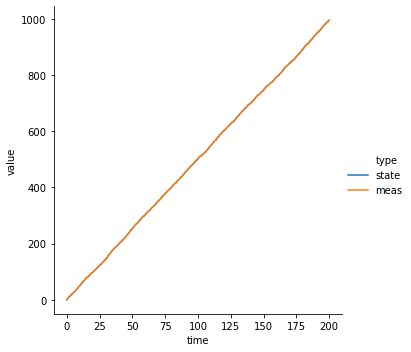

In [34]:
# Simulate some data
key = random.PRNGKey(1)

# parameter values
mu = 5.
sigma = 1.
tau = 0
theta = np.array([mu, sigma, tau])
# data specification
dt = .2
n_obs = 1000
x_init = jnp.array([0.])

# simulate data
key, subkey = random.split(key)
y_meas, x_state = meas_sim(n_obs, x_init, theta, subkey)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "state": jnp.squeeze(x_state),
                         "meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)

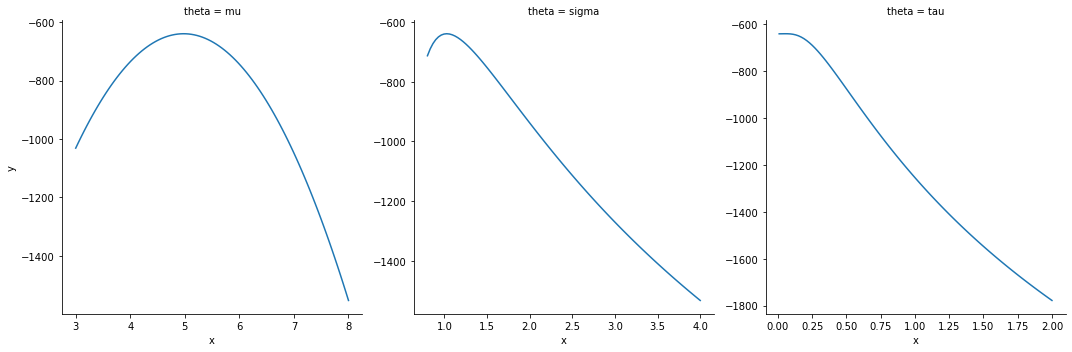

In [35]:
# plot exact likelihood
theta_lims = np.array([[3., 8.], [.8, 4], [.01, 2]])
theta_names = ["mu", "sigma", "tau"]
n_pts = 100

# calculate projection plot
plot_df = proj_data(lambda th: bm_loglik(y_meas, dt, th), theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    facet_kws=dict(sharex=False, sharey=False)
)

In [32]:
# for tau = 0, MLE of mu and sigma are analytically available
mu_hat = jnp.mean(jnp.diff(jnp.squeeze(y_meas)))/dt
sigma_hat = jnp.sqrt(jnp.mean((jnp.diff(jnp.squeeze(y_meas)) - mu*dt)**2)/dt)
sigma_hat2 = jnp.std(jnp.diff(jnp.squeeze(y_meas))) / np.sqrt(dt)
print("mu_hat = ", mu_hat)
print("sigma_hat = ", sigma_hat)
print("sigma_hat2 = ", sigma_hat2)
print("theta = ", theta)
bm_loglik(y_meas, dt, np.array([mu, sigma, tau])) # should be around -1200...

mu_hat =  4.978688733922347
sigma_hat =  1.0262253805296342
sigma_hat2 =  1.0261811232091662
theta =  [8. 4. 2.]


DeviceArray(-640.14805397, dtype=float64)

## Scratch

### Using **NumPy** and **SciPy**

In [7]:
# %load bm_model.py
"""
Brownian motion state space model.

The model is:

```
x_0 ~ pi(x_0) \propto 1
x_t ~ N(x_{t-1} + mu * dt, sigma * sqrt(dt))
y_t ~ N(x_t, tau)
```

The parameter values are `theta = (mu, sigma, tau)`, and `dt` is a global constant.
"""

import numpy as np
import scipy as sp
import scipy.stats


# state-space dimensions
n_meas = 1
n_state = 1


def state_lpdf(x_curr, x_prev, theta):
    """
    Calculates the log-density of `p(x_curr | x_prev, theta)`.

    Args:
        x_curr: State variable at current time `t`.
        x_prev: State variable at previous time `t-1`.
        theta: Parameter value.

    Returns:
        The log-density of `p(x_curr | x_prev, theta)`.
    """
    mu = theta[0]
    sigma = theta[1]
    return np.squeeze(
        sp.stats.norm.logpdf(x_curr, loc=x_prev + mu * dt,
                             scale=sigma * np.sqrt(dt))
    )


def state_sample(x_prev, theta):
    """
    Samples from `x_curr ~ p(x_curr | x_prev, theta)`.

    Args:
        x_prev: State variable at previous time `t-1`.
        theta: Parameter value.

    Returns:
        Sample of the state variable at current time `t`: `x_curr ~ p(x_curr | x_prev, theta)`.
    """
    mu = theta[0]
    sigma = theta[1]
    return sp.stats.norm.rvs(loc=x_prev + mu * dt, scale=sigma * np.sqrt(dt))


def meas_lpdf(y_curr, x_curr, theta):
    """
    Log-density of `p(y_curr | x_curr, theta)`.

    Args:
        y_curr: Measurement variable at current time `t`.
        x_curr: State variable at current time `t`.
        theta: Parameter value.

    Returns:
        The log-density of `p(x_curr | x_prev, theta)`.
    """
    tau = theta[2]
    return np.squeeze(
        sp.stats.norm.logpdf(y_curr, loc=x_curr, scale=tau)
    )


def meas_sample(x_curr, theta):
    """
    Sample from `p(y_curr | x_curr, theta)`.

    Args:
        x_curr: State variable at current time `t`.
        theta: Parameter value.

    Returns:
        Sample of the measurement variable at current time `t`: `y_curr ~ p(y_curr | x_curr, theta)`.
    """
    tau = theta[2]
    return sp.stats.norm.rvs(loc=x_curr, scale=tau)


def init_logw(x_init, y_init, theta):
    """
    Log-weight of the importance sampler for initial state variable `x_init`.

    Suppose that 
    ```
    x_init ~ q(x_init) = q(x_init | y_init, theta)
    ```
    Then function returns
    ```
    logw = log p(x_init | theta) - log q(x_init)
    ```

    Args:
        x_init: State variable at initial time `t = 0`.
        y_init: Measurement variable at initial time `t = 0`.
        theta: Parameter value.

    Returns:
        The log-weight of the importance sampler for `x_init`.
    """
    return -meas_lpdf(x_init, y_init, theta)


def init_sample(y_init, theta):
    """
    Sampling distribution for initial state variable `x_init`. 

    Samples from an importance sampling proposal distribution
    ```
    x_init ~ q(x_init) = q(x_init | y_init, theta)
    ```
    See `init_logw()` for details.

    Args:
        y_init: Measurement variable at initial time `t = 0`.
        theta: Parameter value.

    Returns:
        Sample from the proposal distribution for `x_init`.
    """
    return meas_sample(y_init, theta)


In [8]:
# %load particle_filter.py
"""
Prototype for particle filter using NumPy/SciPy.

The API requires the user to define the following functions:

- `state_lpdf(x_curr, x_last, theta)`: Log-density of `p(x_t | x_{t-1}, theta)`.
- `state_sample(x_last, theta)`: Sample from `x_curr ~ p(x_t | x_{t-1}, theta)`.
- `meas_lpdf(y_curr, x_curr, theta)`: Log-density of `p(y_t | x_t, theta)`.
- `meas_sample(x_curr, theta)`: Sample from `y_curr ~ p(y_t | x_t, theta)`.
- `init_sample(y_init, theta)`: Sample from *proposal* distribution `x_init ~ q(x_init | y_init, theta)`.  See below for details.
- `init_logw(x_init, y_init, theta)`: Log-weights for importance sampler for `x_init`.

For now, additional inputs are specified as global constants.

Importance sampling is used to draw from the initial state variable `x_init` at time `t = 0`.  That is, the proposal distribution is
```
x_init ~ q(x_init) = q(x_init | y_init, theta)
```
as obtained by `init_sample()`.  The samples are then reweighted with log-weights
```
logw = log p(x_init | theta) - log q(x_init)
```
as calculated by `init_logw()`.

The provided functions are:

- `meas_sim(n_obs, x_init, theta)`: Obtain a sample from `y_meas = (y_1, ..., y_T)` and `x_state = (x_1, ..., x_T)`.
- `particle_filter(y_meas, theta, n_particles): Run the particle filter.
- `particle_loglik(logw_particles)`: Compute the particle filter marginal loglikelihoood.
- `particle_smooth(logw, X_particles, ancestor_particles, n_sample)`: Posterior sampling from the particle filter distribution of `p(x_state | y_meas, theta)`.
- `particle_resample(logw)`: A rudimentary particle resampling method.
"""

import numpy as np
import scipy as sp
import scipy.stats


def meas_sim(n_obs, x_init, theta):
    """
    Simulate data from the state-space model.

    Args:
        n_obs: Number of observations to generate.
        x_init: Initial state value at time `t = 0`.
        theta: Parameter value.

    Returns:
        y_meas: The sequence of measurement variables `y_meas = (y_0, ..., y_T)`, where `T = n_obs-1`.
        x_state: The sequence of state variables `x_state = (x_0, ..., x_T)`, where `T = n_obs-1` and `x_0 = x_init`.
    """
    y_meas = np.zeros((n_obs, n_meas))
    x_state = np.zeros((n_obs, n_state))
    x_state[0] = x_init
    for t in range(1, n_obs):
        x_state[t] = state_sample(x_state[t-1], theta)
        y_meas[t] = meas_sample(x_state[t], theta)
    return y_meas, x_state


def particle_resample(logw):
    """
    Particle resampler.

    This basic one just does a multinomial sampler, i.e., sample with replacement proportional to weights.

    Args:
        logw: Vector of `n_particles` unnormalized log-weights.

    Returns:
        Vector of `n_particles` integers between 0 and `n_particles-1`, sampled with replacement with probability vector `exp(logw) / sum(exp(logw))`.
    """
    wgt = np.exp(logw - np.max(logw))
    prob = wgt / np.sum(wgt)
    n_particles = logw.size
    return np.random.choice(np.arange(n_particles), size=n_particles, p=prob)


def particle_filter(y_meas, theta, n_particles):
    """
    Apply particle filter for given value of `theta`.

    Closely follows Algorithm 2 of https://arxiv.org/pdf/1306.3277.pdf.

    Args:
        y_meas: The sequence of `n_obs` measurement variables `y_meas = (y_0, ..., y_T)`, where `T = n_obs-1`.
        theta: Parameter value.
        n_particles: Number of particles.

    Returns:
        A dictionary with elements:
            - `X_particles`: An `ndarray` with leading dimensions `(n_obs, n_particles)` containing the state variable particles.
            - `logw_particles`: An `ndarray` of shape `(n_obs, n_particles)` giving the unnormalized log-weights of each particle at each time point.
            - `ancestor_particles`: An integer `ndarray` of shape `(n_obs, n_particles)` where each element gives the index of the particle's ancestor at the previous time point.  Since the first time point does not have ancestors, the first row of `ancestor_particles` contains all `-1`.
    """
    # memory allocation
    n_obs = y_meas.shape[0]
    X_particles = np.zeros((n_obs, n_particles, n_state))
    logw_particles = np.zeros((n_obs, n_particles))
    ancestor_particles = np.zeros((n_obs, n_particles), dtype=int)
    ancestor_particles[0] = -1  # initial particles have no ancestors
    # initial time point
    for i_part in range(n_particles):
        X_particles[0, i_part] = init_sample(y_meas[0], theta)
        logw_particles[0, i_part] = \
            init_logw(X_particles[0, i_part], y_meas[0], theta) + \
            meas_lpdf(y_meas[0], X_particles[0, i_part], theta)
    # subsequent time points
    for t in range(1, n_obs):
        # resampling step
        ancestor_particles[t] = particle_resample(logw_particles[t-1])
        for i_part in range(n_particles):
            X_particles[t, i_part, :] = state_sample(
                X_particles[t-1, ancestor_particles[t, i_part], :], theta
            )
            logw_particles[t, i_part] = meas_lpdf(
                y_meas[t, :], X_particles[t, i_part, :], theta
            )
    return {
        "X_particles": X_particles,
        "logw_particles": logw_particles,
        "ancestor_particles": ancestor_particles
    }


def particle_loglik(logw_particles):
    """
    Calculate particle filter marginal loglikelihood.

    FIXME: Libbi paper does `logmeanexp` instead of `logsumexp`...

    Args:
        logw_particles: An `ndarray` of shape `(n_obs, n_particles)` giving the unnormalized log-weights of each particle at each time point.        

    Returns:
        Particle filter approximation of 
        ```
        log p(y_meas | theta) = log int p(y_meas | x_state, theta) * p(x_state | theta) dx_state
        ```
    """
    return np.sum(sp.special.logsumexp(logw_particles, axis=1))


def particle_smooth(logw, X_particles, ancestor_particles, n_sample=1):
    """
    Basic particle smoothing algorithm.

    Samples from posterior distribution `p(x_state | x_meas, theta)`.

    Args:
        logw: Vector of `n_particles` unnormalized log-weights at the last time point `t = n_obs-1`.
        X_particles: An `ndarray` with leading dimensions `(n_obs, n_particles)` containing the state variable particles.        
        ancestor_particles: An integer `ndarray` of shape `(n_obs, n_particles)` where each element gives the index of the particle's ancestor at the previous time point.
        n_sample: Number of draws of `x_state` to return.

    Returns:
        An `ndarray` with leading dimension `n_sample` corresponding to as many samples from the particle filter approximation to the posterior distribution `p(x_state | x_meas, theta)`.
    """
    wgt = np.exp(logw - np.max(logw))
    prob = wgt / np.sum(wgt)
    n_particles = logw.size
    n_obs = X_particles.shape[0]
    n_state = X_particles.shape[2]
    x_state = np.zeros((n_sample, n_obs, n_state))
    for i_samp in range(n_sample):
        i_part = np.random.choice(np.arange(n_particles), size=1, p=prob)
        # i_part_T = i_part
        x_state[i_samp, n_obs-1] = X_particles[n_obs-1, i_part, :]
        for i_obs in reversed(range(n_obs-1)):
            i_part = ancestor_particles[i_obs+1, i_part]
            x_state[i_samp, i_obs] = X_particles[i_obs, i_part, :]
    return x_state  # , i_part_T


In [9]:
# %load test_particle_filter.py
# parameter values
mu = 5
sigma = 1
tau = .1
theta = np.array([mu, sigma, tau])

# data specification
dt = .1
n_obs = 5
x_init = np.array([0.])

# simulate data
y_meas, x_state = meas_sim(n_obs, x_init, theta)

print("y_meas = \n", y_meas)
print("x_init = \n", x_init)
print("x_state = \n", x_state)

n_particles = 7
pf_out = particle_filter(y_meas, theta, n_particles)
pf_out = particle_filter(y_meas, theta, n_particles)
pf_out = particle_filter(y_meas, theta, n_particles)

print("pf_out = \n", pf_out)

# calculate marginal loglikelihood
pf_loglik = particle_loglik(pf_out["logw_particles"])

print("pf_loglik = \n", pf_loglik)

# sample from posterior `p(x_{0:T} | y_{0:T}, theta)`
n_sample = 11
X_state = particle_smooth(
    pf_out["logw_particles"][n_obs-1],
    pf_out["X_particles"],
    pf_out["ancestor_particles"],
    n_sample
)

print("X_state = \n", X_state)


y_meas = 
 [[0.        ]
 [0.14462245]
 [0.53286509]
 [1.33334505]
 [1.63556777]]
x_init = 
 [0.]
x_state = 
 [[0.        ]
 [0.15128802]
 [0.38101611]
 [1.36853393]
 [1.52487332]]
pf_out = 
 {'X_particles': array([[[ 0.01341076],
        [-0.09413561],
        [ 0.1697348 ],
        [-0.00397668],
        [-0.1175573 ],
        [-0.05231039],
        [ 0.131337  ]],

       [[ 0.80266305],
        [ 0.55421151],
        [ 1.17826462],
        [ 0.2150805 ],
        [ 0.02685536],
        [ 0.33141021],
        [ 0.79690774]],

       [[ 0.54192095],
        [ 0.64886496],
        [ 0.67251241],
        [ 0.52004983],
        [ 0.82764679],
        [ 0.50557272],
        [ 0.35048103]],

       [[ 0.5414436 ],
        [ 0.80281305],
        [ 1.3559858 ],
        [ 1.20637001],
        [ 1.30017244],
        [ 1.20859464],
        [ 1.26337759]],

       [[ 1.73437989],
        [ 1.61909548],
        [ 1.91045202],
        [ 1.5847115 ],
        [ 1.97605676],
        [ 1.42677837],
  

In [48]:
state_lpdf(x_state[1], x_state[0], theta)

DeviceArray([-0.33247287], dtype=float64)

In [186]:
import numpy as np
import scipy as sp
import scipy.stats

def state_lpdf(x_curr, x_last, theta):
    mu = theta[0]
    sigma = theta[1]
    return sp.stats.norm.logpdf(x_curr, loc = x_last + mu * dt, scale = sigma * np.sqrt(dt))


def state_sample(x_last, theta):
    mu = theta[0]
    sigma = theta[1]
    return sp.stats.norm.rvs(loc = x_last + mu * dt, scale = sigma * np.sqrt(dt))

def meas_lpdf(y_curr, x_curr, theta):
    tau = theta[2]
    return sp.stats.norm.logpdf(y_curr, loc = x_curr, scale = tau)

def meas_sample(x_curr, theta):
    tau = theta[2]
    return sp.stats.norm.rvs(loc = x_curr, scale = tau)

# storage
#
# first do it column-major
# n_state, n_particles, n_obs
# [:,:, i_obs] represents the state of the pf  up to a given point
# [:,i_part, i_obs] is the calculation for each particle at a given point
#
# now row-major

# first a helper function
def np_intarray(dims):
    return np.reshape(np.arange(np.prod(dims))+0., dims, order = 'C')

n_meas = 1
n_state = 1
n_particles = 7
n_obs = 5
n_tot = n_state * n_particles * n_obs
#X_particles = np.arange(n_tot)
#X_particles = np.reshape(X_particles, [n_obs, n_particles, n_state], order = 'C')
X_particles = np_intarray([n_obs, n_particles, n_state])
i_obs = 0
# X_particles[i_obs]

# weights
#logw_particles = np.reshape(np.arange(n_particles * n_obs), [n_obs, n_particles])
logw_particles = np_intarray([n_obs, n_particles])
logw_particles[i_obs]

# ancestors
ant_particles = np_intarray([n_obs, n_particles]).astype(int)
# first set of particles have no ancestors
ant_particles[0] = 0

# let's try it
mu = 5
sigma = 1
tau = .1
theta = np.array([mu, sigma, tau])
dt = .1

# first simulate data
y_obs = np_intarray([n_obs, n_meas])
x_lat = np_intarray([n_obs, n_state])
x_prev = 0.
for t in range(n_obs):
    x_lat[t] = state_sample(x_prev, theta)
    y_obs[t] = meas_sample(x_lat[t], theta)
    x_prev = x_lat[t]
x_lat_true = x_lat # reuse this as a variable name
y_obs

array([[0.34141049],
       [0.74321696],
       [0.83085765],
       [1.98326492],
       [2.79380972]])

In [187]:
# now particle filter

# sample from normalized weights with replacement
def particle_resample(logw):
    mx = np.max(logw)
    wgt = np.exp(logw - mx)
    n_particles = logw.size
    #return sp.stats.multinomial.rvs(n_particles, wgt/np.sum(wgt))
    return np.random.choice(np.arange(n_particles), size = n_particles, p = wgt / np.sum(wgt))

#sp.stats.multinomial.rvs(1, [.25, .25, .25, .25], 10)
#np.random.choice(np.arange(4), size = 10, p = [.25, .25, .25, .25])

#particle_resample(np.array([0., 0., 0.]))

# using flat prior on x_0 
for i_part in range(n_particles):
    X_particles[0,i_part,:] = meas_sample(y_obs[0,:], theta)
    #logw_particles[0,i_part] = meas_lpdf(X_particles[0,i_part,:], y_obs[0], theta)
    logw_particles[0,i_part] = 0. # sample directly from posterior p(x_0 | y_0, theta)

# remaining observations
for t in range(1, n_obs):
    # resampling step
    ant_particles[t] = particle_resample(logw_particles[t-1])
    for i_part in range(n_particles):
        X_particles[t,i_part,:] = state_sample(X_particles[t-1,ant_particles[t,i_part],:], theta)
        logw_particles[t, i_part] = meas_lpdf(y_obs[t,:], X_particles[t,i_part,:], theta)

print(X_particles)
print(logw_particles)
print(ant_particles)

[[[0.25876451]
  [0.31918554]
  [0.26557652]
  [0.33072027]
  [0.38542672]
  [0.3636304 ]
  [0.42153657]]

 [[1.11239371]
  [1.29589014]
  [0.95854899]
  [1.42828306]
  [0.53992602]
  [0.63031026]
  [0.71932819]]

 [[0.70597072]
  [1.38912009]
  [1.84765476]
  [0.94279953]
  [1.72416633]
  [1.40544201]
  [1.0829206 ]]

 [[1.48140934]
  [1.75805587]
  [1.10969347]
  [1.86911294]
  [1.16602461]
  [1.93583039]
  [1.02073788]]

 [[2.30232723]
  [2.48872364]
  [2.02646744]
  [2.44285898]
  [1.9745851 ]
  [2.83355214]
  [2.41469545]]]
[[  0.           0.           0.           0.           0.
    0.           0.        ]
 [ -5.43092725 -13.88873598  -0.93474776 -22.08213157  -0.68271372
    0.74625047   1.3551129 ]
 [  0.60380926 -14.19920086 -50.31017205   0.75709729 -38.5163734
  -15.12371285  -1.79313992]
 [-11.20930491  -1.15230939 -36.77270752   0.73211276 -32.01043983
    1.2711448  -44.93926934]
 [-10.69410502  -3.27022919 -28.05706219  -4.77467435 -32.17280205
    1.30467354  -5.8027

In [163]:
ant_particles

array([[0, 0, 0, 0, 0, 0, 0],
       [2, 0, 1, 1, 1, 1, 1],
       [0, 0, 2, 0, 0, 4, 1],
       [0, 0, 0, 6, 1, 0, 0],
       [0, 0, 0, 7, 0, 0, 0]])

In [ ]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open('particle_filter.py') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

In [95]:
plot_df = (pd.DataFrame(np.concatenate((plot_data[0], plot_data[1])).T,
                        columns = [a+b for b in map(str, ["_x", "_y"]) for a in theta_names])
           .melt()
          )
plot_df[["theta", "axis"]] = plot_df["variable"].str.split("_", 1, expand=True)
plot_df = plot_df[["axis", "theta", "value"]]
#plot_df
plot_df.pivot(columns="axis", values=["theta", "value"])
#df = pd.DataFrame({'foo': ['one', 'one', 'one', 'two', 'two',
#                           'two'],
#                   'bar': ['A', 'B', 'C', 'A', 'B', 'C'],
#                   'baz': [1, 2, 3, 4, 5, 6],
#                   'zoo': ['x', 'y', 'z', 'q', 'w', 't']})
#df
#df.pivot(index='foo', columns='bar', values='baz')

theta         value         
axis     x    y        x        y
0       mu  NaN        4      NaN
1       mu  NaN   4.0202      NaN
2       mu  NaN   4.0404      NaN
3       mu  NaN  4.06061      NaN
4       mu  NaN  4.08081      NaN
..     ...  ...      ...      ...
595    NaN  tau      NaN -542.084
596    NaN  tau      NaN -534.325
597    NaN  tau      NaN -526.743
598    NaN  tau      NaN -519.333
599    NaN  tau      NaN  -512.09

[600 rows x 4 columns]

In [29]:
pd.DataFrame(
    jnp.array([[4, 7, 10],
     [5, 8, 11],
     [6, 9, 12]]), 
    #index=[1, 2, 3], 
    columns=['a', 'b', 'c'])

,a,b,c
0,4,7,10
1,5,8,11
2,6,9,12
